In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adv_machine.utils import *
from adv_machine.get_prices import get_bulk_ohlc
from adv_machine.universe import Universe
from adv_machine.backtester import calculate_cumulative_pnl_v1


In [264]:
import pandas as pd

# Charger le fichier available_stock.csv
df_stocks = pd.read_csv('available_stock.csv', delimiter=';')

# Extraire la liste des tickers disponibles
available_stocks = df_stocks['Ticker'].tolist()

print(f"Nombre d'actifs disponibles : {len(available_stocks)}")
print(f"Exemple d'actifs : {available_stocks[:5]}")

Nombre d'actifs disponibles : 106328
Exemple d'actifs : ['OEDV', 'AAPL', 'BAC', 'AMZN', 'T']


In [265]:
########################################
# 1. IMPORTS
########################################
import pandas as pd
from adv_machine.get_prices import get_bulk_ohlc
from adv_machine.ohlc_to_feature import ohlc_to_feature

########################################
# 2. CONFIGURATION DES FEATURES
########################################
config_features = [
    {
        "type": "return_pct",
        "params": {"period": 10}
    },
    {
        "type": "distance_from_ma",
        "params": {"period": 20}
    },
    {
        "type": "distance_from_high",
        "params": {"period": 20}
    },
    {
        "type": "realized_volatility",
        "params": {"period": 20}
    },
    
    {
        "type": "calmar_ratio",
        "params": {"period": 252}
    },
    {
        "type": "skew",
        "params": {"period": 20}
    }
]



In [266]:
# 1. Calcul des features avec log-returns et targets
tickers = ['AMZN', "AAPL"  , "GOOG","BAC","ADBE","NVS", "T"]
start_date = "2021-01-01"
end_date = "2023-06-30"
price_data = get_bulk_ohlc(tickers, start_date, end_date)

# Ajout des features pour chaque ticker
results_direct = {}
for ticker, df_ohlc in price_data.items():
    df_ohlc = df_ohlc.dropna()

    # Calcul des log-returns
    df_ohlc["log_return"] = (df_ohlc["close"] / df_ohlc["close"].shift(1)).apply(np.log)
    
    # Création de la colonne target (1 si log_return suivant > 0, sinon 0)
    df_ohlc["target"] = (df_ohlc["log_return"].shift(-1) < 0).astype(int)

    # Calcul des features à partir de la configuration
    for feat_conf in config_features:
        feature_name = feat_conf["type"]
        feature_params = feat_conf["params"]
        series_feat = ohlc_to_feature(
            ohlc=df_ohlc,
            feature=feature_name,
            config_feature=feature_params,
            verbose=0
        )
        df_ohlc[series_feat.name] = series_feat
    
    # Ajouter les données transformées au dictionnaire
    results_direct[ticker] = df_ohlc

# Fusionner les données de tous les tickers
features_data = pd.concat([df.assign(ticker=t) for t, df in results_direct.items()])
features_data.reset_index(inplace=True)

# Suppression des lignes contenant des valeurs manquantes (provoquées par shift)
#features_data.dropna(inplace=True)

# Aperçu des données transformées
print(features_data.head())

        Date        open        high         low       close    volume  \
0 2021-01-04  163.500000  163.600006  157.201004  159.331497  88228000   
1 2021-01-05  158.300507  161.169006  158.253006  160.925507  53110000   
2 2021-01-06  157.324005  159.875504  156.557999  156.919006  87896000   
3 2021-01-07  157.850006  160.427002  157.750000  158.108002  70290000   
4 2021-01-08  159.000000  159.531998  157.110001  159.134995  70754000   

   log_return  target  return_pct_period_10  distance_from_ma_period_20  \
0         NaN       0                   NaN                         NaN   
1    0.009955       1                   NaN                         NaN   
2   -0.025212       0                   NaN                         NaN   
3    0.007549       0                   NaN                         NaN   
4    0.006475       1                   NaN                         NaN   

   distance_from_high_period_20  realized_volatility_period_20  \
0                           NaN       

In [267]:
features_data

,Date,open,high,low,close,volume,log_return,target,return_pct_period_10,distance_from_ma_period_20,distance_from_high_period_20,realized_volatility_period_20,calmar_ratio_period_252,skew_period_20,ticker
0,2021-01-04,163.500000,163.600006,157.201004,159.331497,88228000,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
1,2021-01-05,158.300507,161.169006,158.253006,160.925507,53110000,0.009955,1,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
2,2021-01-06,157.324005,159.875504,156.557999,156.919006,87896000,-0.025212,0,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
3,2021-01-07,157.850006,160.427002,157.750000,158.108002,70290000,0.007549,0,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
4,2021-01-08,159.000000,159.531998,157.110001,159.134995,70754000,0.006475,1,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,2023-06-23,14.011791,14.101437,13.823533,13.850427,37372800,-0.008379,0,-0.038581,-0.016925,-0.042158,0.359403,-0.661886,-1.066739,T
4378,2023-06-26,13.859391,14.029719,13.832497,14.011790,28616600,0.011583,0,-0.020063,-0.006989,-0.030998,0.331540,-0.669027,-0.691264,T
4379,2023-06-27,13.940073,14.244872,13.922143,14.200048,31457000,0.013346,1,-0.005650,0.005267,-0.017979,0.325826,-0.682563,-0.834687,T
4380,2023-06-28,14.173155,14.200049,13.993861,14.146260,26156400,-0.003795,0,-0.002528,0.001015,-0.021699,0.326661,-0.665341,-0.710935,T


In [268]:
# Initialisation des conteneurs pour les données d'entraînement et de test
X_train_full = []
y_train_full = []
X_test_full = []
y_test_full = []

# Boucle sur chaque ticker pour séparer les données
for ticker in features_data["ticker"].unique():
    # Filtrer les données pour le ticker actuel
    ticker_data = features_data[features_data["ticker"] == ticker]
    #print(ticker_data)
    # Création des ensembles d'entraînement et de test
    train_data = ticker_data[ticker_data["Date"] < "2023-01-01"]
    test_data = ticker_data[ticker_data["Date"] >= "2023-01-01"]

    # Colonnes des features (exclure les colonnes non liées aux features)
    feature_cols = [col for col in ticker_data.columns if col not in ["ticker", "target"]]

    # Filtrer uniquement les colonnes numériques
    X_train = train_data[feature_cols]#.select_dtypes(include=[np.number])
    X_test = test_data[feature_cols]#.select_dtypes(include=[np.number])
    #print(X_train)
    # Ajouter la colonne 'ticker' aux features
    X_train["ticker"] = ticker
    X_test["ticker"] = ticker

    # Données d'entraînement
    y_train = train_data["target"]
    y_test = test_data["target"]

    # Supprimer les indices non correspondants
    y_train = y_train[X_train.index]
    y_test = y_test[X_test.index]

    # Ajouter les données du ticker au conteneur global
    X_train_full.append(X_train)
    y_train_full.append(y_train)
    X_test_full.append(X_test)
    y_test_full.append(y_test)

# Concaténer les données de tous les tickers
X_train_full = pd.concat(X_train_full, axis=0)
y_train_full = pd.concat(y_train_full, axis=0)
X_test_full = pd.concat(X_test_full, axis=0)
y_test_full = pd.concat(y_test_full, axis=0)

# Vérification des shapes
print(f"Shape de X_train_full: {X_train_full.shape}, y_train_full: {y_train_full.shape}")
print(f"Shape de X_test_full: {X_test_full.shape}, y_test_full: {y_test_full.shape}")

Shape de X_train_full: (3521, 14), y_train_full: (3521,)
Shape de X_test_full: (861, 14), y_test_full: (861,)


/var/folders/nk/b2qh3mjd1fbbv82_5r4mxqf00000gn/T/ipykernel_24099/657497324.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["ticker"] = ticker
/var/folders/nk/b2qh3mjd1fbbv82_5r4mxqf00000gn/T/ipykernel_24099/657497324.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["ticker"] = ticker
/var/folders/nk/b2qh3mjd1fbbv82_5r4mxqf00000gn/T/ipykernel_24099/657497324.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [269]:
X_train_full

,Date,open,high,low,close,volume,log_return,return_pct_period_10,distance_from_ma_period_20,distance_from_high_period_20,realized_volatility_period_20,calmar_ratio_period_252,skew_period_20,ticker
0,2021-01-04,163.500000,163.600006,157.201004,159.331497,88228000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
1,2021-01-05,158.300507,161.169006,158.253006,160.925507,53110000,0.009955,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
2,2021-01-06,157.324005,159.875504,156.557999,156.919006,87896000,-0.025212,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
3,2021-01-07,157.850006,160.427002,157.750000,158.108002,70290000,0.007549,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
4,2021-01-08,159.000000,159.531998,157.110001,159.134995,70754000,0.006475,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4254,2022-12-23,15.832419,15.963121,15.771425,15.954408,25164100,0.002187,-0.040859,-0.025260,-0.061988,0.265012,0.162182,-0.453813,T
4255,2022-12-27,15.902125,16.137390,15.875984,16.085108,30382500,0.008159,-0.043523,-0.016332,-0.054303,0.263729,0.204658,-0.684553,T
4256,2022-12-28,16.076394,16.163527,15.849843,15.875982,26632300,-0.013086,-0.047071,-0.027073,-0.066598,0.266426,0.151752,-0.473016,T
4257,2022-12-29,15.919554,16.163531,15.893413,16.076397,23765900,0.012545,-0.023810,-0.012603,-0.054815,0.263310,0.223285,-0.490357,T


In [270]:
y_train_full

0       0
1       1
2       0
3       0
4       1
       ..
4254    0
4255    1
4256    0
4257    1
4258    0
Name: target, Length: 3521, dtype: int64

In [271]:
X_test_full

,Date,open,high,low,close,volume,log_return,return_pct_period_10,distance_from_ma_period_20,distance_from_high_period_20,realized_volatility_period_20,calmar_ratio_period_252,skew_period_20,ticker
503,2023-01-03,85.459999,86.959999,84.209999,85.820000,76706000,0.021435,-0.023219,-0.015188,-0.108364,0.500981,-0.933417,-0.057049,AMZN
504,2023-01-04,86.550003,86.980003,83.360001,85.139999,68885100,-0.007955,0.002591,-0.019689,-0.115429,0.505062,-0.968276,-0.119539,AMZN
505,2023-01-05,85.330002,85.419998,83.070000,83.120003,67930800,-0.024012,-0.024299,-0.040113,-0.136416,0.499347,-0.974974,-0.106255,AMZN
506,2023-01-06,83.029999,86.400002,81.430000,86.080002,83303400,0.034992,-0.007952,-0.004562,-0.105662,0.516240,-0.921633,-0.043879,AMZN
507,2023-01-09,87.459999,89.480003,87.080002,87.360001,65266100,0.014760,0.042607,0.011990,-0.092364,0.519463,-0.899613,-0.035460,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,2023-06-23,14.011791,14.101437,13.823533,13.850427,37372800,-0.008379,-0.038581,-0.016925,-0.042158,0.359403,-0.661886,-1.066739,T
4378,2023-06-26,13.859391,14.029719,13.832497,14.011790,28616600,0.011583,-0.020063,-0.006989,-0.030998,0.331540,-0.669027,-0.691264,T
4379,2023-06-27,13.940073,14.244872,13.922143,14.200048,31457000,0.013346,-0.005650,0.005267,-0.017979,0.325826,-0.682563,-0.834687,T
4380,2023-06-28,14.173155,14.200049,13.993861,14.146260,26156400,-0.003795,-0.002528,0.001015,-0.021699,0.326661,-0.665341,-0.710935,T


In [272]:
class ObjectiveBinary:
    def gradient(self, y_true, y_pred):
        p = 1 / (1 + np.exp(-y_pred))  # Sigmoïde pour obtenir des probabilités
        return p - y_true

    def hessian(self, y_true, y_pred):
        p = 1 / (1 + np.exp(-y_pred))
        return p * (1 - p)

    def loss(self, y_true, y_pred):
        eps = 1e-15
        p = 1 / (1 + np.exp(-y_pred))
        p = np.clip(p, eps, 1 - eps)
        return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

In [257]:
from adv_machine.model import XGBoostModel

# Configuration du modèle
xgb_params = {
    "max_depth": 3,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "reg_lambda": 1.0,
    "gamma": 0.1
}


# Initialisation des modèles pour chaque ticker
models = {}
objective = ObjectiveBinary()

# Boucle pour entraîner un modèle par ticker
for ticker in features_data["ticker"].unique():
    print(f"Entraînement du modèle pour le ticker : {ticker}")

    # Filtrer les données pour ce ticker
    ticker_train_data = X_train_full[X_train_full["ticker"] == ticker]
    ticker_y_train = y_train_full[X_train_full["ticker"] == ticker]

    # Supprimer la colonne 'ticker' des features
    ticker_X_train = ticker_train_data.drop(columns=["ticker"])

    # Vérification des dimensions
    print(f"Shape de X_train pour {ticker}: {ticker_X_train.shape}, y_train: {ticker_y_train.shape}")

    # Instancier et entraîner le modèle
    model = XGBoostModel(params=xgb_params, random_seed=42)
    # Entraîner le modèle
    model.fit(
        ticker_X_train.drop(columns=["Date"], errors="ignore"),  # Suppression des colonnes non pertinentes
        ticker_y_train,  # Cible d'entraînement
        objective=objective,  # Fonction objectif
        num_boost_round=50,  # Nombre de tours d'entraînement
        verbose=True  # Affichage des logs
    )

    # Sauvegarder le modèle pour ce ticker
    models[ticker] = model

print("Entraînement terminé pour tous les tickers.")

Entraînement du modèle pour le ticker : AMZN
Shape de X_train pour AMZN: (503, 13), y_train: (503,)
[0] train loss = 0.7196038231463094
[1] train loss = 0.714134922639676
[2] train loss = 0.714134922639676
[3] train loss = 0.7018816096667944
[4] train loss = 0.6939472515235562
[5] train loss = 0.6939472515235562
[6] train loss = 0.6939472515235562
[7] train loss = 0.6905464526977663


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[8] train loss = 0.689097331044161
[9] train loss = 0.6845842589963882
[10] train loss = 0.6800918006231761


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[11] train loss = 0.67374163482225
[12] train loss = 0.67374163482225
[13] train loss = 0.6688775428420851
[14] train loss = 0.6688775428420851
[15] train loss = 0.6688775428420851
[16] train loss = 0.6688775428420851
[17] train loss = 0.6639319807162287
[18] train loss = 0.6639319807162287
[19] train loss = 0.660487764496869


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[20] train loss = 0.6593057651276311
[21] train loss = 0.6575085745977298
[22] train loss = 0.6521161137371068
[23] train loss = 0.6521161137371068


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[24] train loss = 0.6471742210408884
[25] train loss = 0.6471742210408884
[26] train loss = 0.6471742210408884
[27] train loss = 0.6471742210408884
[28] train loss = 0.6471742210408884
[29] train loss = 0.6471742210408884
[30] train loss = 0.6420089128591104
[31] train loss = 0.6368472807279103


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[32] train loss = 0.6317844063301352
[33] train loss = 0.6317844063301352
[34] train loss = 0.6301185241872127
[35] train loss = 0.6279896450771647
[36] train loss = 0.6279896450771647
[37] train loss = 0.6279896450771647


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[38] train loss = 0.6267607644996823
[39] train loss = 0.6267607644996823
[40] train loss = 0.6267607644996823
[41] train loss = 0.6267607644996823
[42] train loss = 0.6267607644996823
[43] train loss = 0.6267607644996823
[44] train loss = 0.6267607644996823
[45] train loss = 0.6267607644996823
[46] train loss = 0.6267607644996823
[47] train loss = 0.6267607644996823


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[48] train loss = 0.6267607644996823
[49] train loss = 0.6267607644996823
Entraînement du modèle pour le ticker : AAPL
Shape de X_train pour AAPL: (503, 13), y_train: (503,)
[0] train loss = 0.725568037858039
[1] train loss = 0.7107050714461506
[2] train loss = 0.710145559658194
[3] train loss = 0.6967565998910321


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[4] train loss = 0.690876135493257
[5] train loss = 0.6897943234711627
[6] train loss = 0.6838535733003158
[7] train loss = 0.6802403127783677
[8] train loss = 0.6760106926944677
[9] train loss = 0.6712148431355576


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[10] train loss = 0.6645198304730707
[11] train loss = 0.6623149360555742
[12] train loss = 0.6531601250330027
[13] train loss = 0.6531601250330027
[14] train loss = 0.6458949544498613


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[15] train loss = 0.6405987525430744
[16] train loss = 0.6337225004590373
[17] train loss = 0.6305124488369686
[18] train loss = 0.6247293241614177
[19] train loss = 0.6188828703469583
[20] train loss = 0.6188828703469583
[21] train loss = 0.6188828703469583


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[22] train loss = 0.6142607005542228
[23] train loss = 0.6142607005542228
[24] train loss = 0.6109037632273303
[25] train loss = 0.608402759412489
[26] train loss = 0.6055889695137294


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[27] train loss = 0.6034771524626917
[28] train loss = 0.6034771524626917
[29] train loss = 0.6034771524626917
[30] train loss = 0.5989290067158863
[31] train loss = 0.5937545374923084
[32] train loss = 0.5913621351941071
[33] train loss = 0.5891364207654717
[34] train loss = 0.5891364207654717


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[35] train loss = 0.5859727334220605
[36] train loss = 0.5837270107321596
[37] train loss = 0.5791685603705874
[38] train loss = 0.578504711104869
[39] train loss = 0.578504711104869


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[40] train loss = 0.578504711104869
[41] train loss = 0.578504711104869
[42] train loss = 0.5753142923103279
[43] train loss = 0.5727992002501326
[44] train loss = 0.5712393532552613
[45] train loss = 0.5712393532552613
[46] train loss = 0.5688181600531816
[47] train loss = 0.5688181600531816


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[48] train loss = 0.5671854454318328
[49] train loss = 0.5671854454318328
Entraînement du modèle pour le ticker : GOOG
Shape de X_train pour GOOG: (503, 13), y_train: (503,)
[0] train loss = 0.7168926920483925
[1] train loss = 0.70855029515165
[2] train loss = 0.6982858021182384
[3] train loss = 0.6982858021182384


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[4] train loss = 0.6900313693819046
[5] train loss = 0.6876363494448999
[6] train loss = 0.6876363494448999
[7] train loss = 0.6876363494448999
[8] train loss = 0.6876363494448999
[9] train loss = 0.6876363494448999
[10] train loss = 0.6876363494448999
[11] train loss = 0.6876363494448999
[12] train loss = 0.6876363494448999
[13] train loss = 0.6876363494448999


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[14] train loss = 0.6876363494448999
[15] train loss = 0.6833394009922089
[16] train loss = 0.6777522859677143
[17] train loss = 0.6678299095686808
[18] train loss = 0.6678299095686808
[19] train loss = 0.6689145955666441


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[20] train loss = 0.6689145955666441
[21] train loss = 0.6689145955666441
[22] train loss = 0.6607450462453617
[23] train loss = 0.6607450462453617
[24] train loss = 0.6607450462453617
[25] train loss = 0.6519438454179746
[26] train loss = 0.6519438454179746
[27] train loss = 0.6519438454179746


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[28] train loss = 0.6519438454179746
[29] train loss = 0.6519438454179746
[30] train loss = 0.6519438454179746
[31] train loss = 0.6493842336770047
[32] train loss = 0.6413854466652206
[33] train loss = 0.6383881258526091


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \


[34] train loss = 0.6347389343184892
[35] train loss = 0.633216849602993
[36] train loss = 0.633216849602993
[37] train loss = 0.6312752138627131
[38] train loss = 0.6277867627428252
[39] train loss = 0.6277867627428252
[40] train loss = 0.6225000230513021
[41] train loss = 0.6225000230513021
[42] train loss = 0.6185787471518626
[43] train loss = 0.6148657104807375


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[44] train loss = 0.6148657104807375
[45] train loss = 0.6092753821005082


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \


[46] train loss = 0.6092753821005082
[47] train loss = 0.6075091266382663
[48] train loss = 0.6049649705012747
[49] train loss = 0.6032430550445838
Entraînement du modèle pour le ticker : BAC
Shape de X_train pour BAC: (503, 13), y_train: (503,)
[0] train loss = 0.725568037858039
[1] train loss = 0.7101335305573031
[2] train loss = 0.7050815211930755
[3] train loss = 0.7050815211930755
[4] train loss = 0.7050815211930755
[5] train loss = 0.7050815211930755


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[6] train loss = 0.7042517185588795
[7] train loss = 0.6990857936931009
[8] train loss = 0.6990857936931009


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[9] train loss = 0.6908891335218964
[10] train loss = 0.6830527424451374
[11] train loss = 0.6830527424451374
[12] train loss = 0.6830527424451374
[13] train loss = 0.676530973710323
[14] train loss = 0.6769208859723189
[15] train loss = 0.6718125083115449
[16] train loss = 0.6718125083115449
[17] train loss = 0.6628218675776634


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[18] train loss = 0.6598917468652936
[19] train loss = 0.6539521316067989
[20] train loss = 0.6534494107865009
[21] train loss = 0.6534494107865009


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[22] train loss = 0.6534494107865009
[23] train loss = 0.6503350512401475
[24] train loss = 0.6447650458856907
[25] train loss = 0.6412605312915496
[26] train loss = 0.6374279197101657
[27] train loss = 0.6374279197101657
[28] train loss = 0.6370194179057085
[29] train loss = 0.6370194179057085
[30] train loss = 0.6370194179057085


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[31] train loss = 0.6361577714074629
[32] train loss = 0.6361577714074629
[33] train loss = 0.6361577714074629


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[34] train loss = 0.6309839815259249
[35] train loss = 0.6309839815259249
[36] train loss = 0.6309839815259249
[37] train loss = 0.6309839815259249
[38] train loss = 0.6309839815259249
[39] train loss = 0.6251768265446221
[40] train loss = 0.6249034888845322
[41] train loss = 0.6249034888845322
[42] train loss = 0.6249034888845322
[43] train loss = 0.6249034888845322
[44] train loss = 0.6255022801527327
[45] train loss = 0.6255022801527327


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[46] train loss = 0.6255022801527327
[47] train loss = 0.6255022801527327
[48] train loss = 0.6255022801527327
[49] train loss = 0.6255022801527327
Entraînement du modèle pour le ticker : ADBE
Shape de X_train pour ADBE: (503, 13), y_train: (503,)
[0] train loss = 0.7127961299064779
[1] train loss = 0.7020709650480969


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[2] train loss = 0.6901441810840003
[3] train loss = 0.6901441810840003
[4] train loss = 0.6819419426695836
[5] train loss = 0.675942528783289
[6] train loss = 0.675942528783289
[7] train loss = 0.6754595487340754
[8] train loss = 0.6677681757251267


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[9] train loss = 0.6677681757251267
[10] train loss = 0.6677681757251267
[11] train loss = 0.6619736952968945
[12] train loss = 0.6619736952968945
[13] train loss = 0.6619736952968945
[14] train loss = 0.6567726139549285
[15] train loss = 0.6567726139549285


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[16] train loss = 0.650309410174573
[17] train loss = 0.6467018482392819
[18] train loss = 0.6403040887308294
[19] train loss = 0.6403040887308294
[20] train loss = 0.6403040887308294
[21] train loss = 0.6369879051008449


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[22] train loss = 0.6341712836345021
[23] train loss = 0.6330661132460604
[24] train loss = 0.6330661132460604
[25] train loss = 0.6285715917397227
[26] train loss = 0.6285715917397227
[27] train loss = 0.6285715917397227
[28] train loss = 0.6262776182775597


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[29] train loss = 0.6262776182775597
[30] train loss = 0.6262776182775597
[31] train loss = 0.621255941858442
[32] train loss = 0.621255941858442
[33] train loss = 0.621255941858442
[34] train loss = 0.6194667029012405
[35] train loss = 0.6178443959712085


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[36] train loss = 0.6143104403162672
[37] train loss = 0.6143104403162672
[38] train loss = 0.6143104403162672
[39] train loss = 0.61091878329745
[40] train loss = 0.61091878329745
[41] train loss = 0.61091878329745
[42] train loss = 0.61091878329745
[43] train loss = 0.61091878329745


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[44] train loss = 0.61091878329745
[45] train loss = 0.6096287055708193
[46] train loss = 0.6096287055708193
[47] train loss = 0.6096287055708193
[48] train loss = 0.6096287055708193
[49] train loss = 0.6085184148519346
Entraînement du modèle pour le ticker : NVS
Shape de X_train pour NVS: (503, 13), y_train: (503,)
[0] train loss = 0.7129675936167604
[1] train loss = 0.7129675936167604


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[2] train loss = 0.7024029701709595
[3] train loss = 0.6939621300322508
[4] train loss = 0.6881033331718113
[5] train loss = 0.6754850895204629


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[6] train loss = 0.668741792685024
[7] train loss = 0.668741792685024
[8] train loss = 0.6619893260614608
[9] train loss = 0.6551028350662584
[10] train loss = 0.6528868588407137
[11] train loss = 0.6466500452690346
[12] train loss = 0.6434864010362392


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[13] train loss = 0.6357648620239409
[14] train loss = 0.6310549754726248
[15] train loss = 0.6256357620024594
[16] train loss = 0.6256357620024594


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[17] train loss = 0.619758377687515
[18] train loss = 0.61753220210583
[19] train loss = 0.613804476196791
[20] train loss = 0.6112935143858418
[21] train loss = 0.6098071562525231
[22] train loss = 0.6063735033587236
[23] train loss = 0.6063735033587236


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[24] train loss = 0.6032257956694395
[25] train loss = 0.6003527363471335
[26] train loss = 0.595563136672419
[27] train loss = 0.5934355520707549


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[28] train loss = 0.5927410248803613
[29] train loss = 0.5927410248803613
[30] train loss = 0.5875238691015042
[31] train loss = 0.5861475737497149
[32] train loss = 0.5837260078244031
[33] train loss = 0.5796196458614429
[34] train loss = 0.5796196458614429
[35] train loss = 0.5756260644932526
[36] train loss = 0.5713304787604099


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[37] train loss = 0.5693431726096914
[38] train loss = 0.569021185693679


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[39] train loss = 0.5669939537496891
[40] train loss = 0.5669939537496891
[41] train loss = 0.5669939537496891
[42] train loss = 0.5669939537496891
[43] train loss = 0.5669939537496891
[44] train loss = 0.5669939537496891
[45] train loss = 0.5619585926148182
[46] train loss = 0.5619585926148182
[47] train loss = 0.5619585926148182
[48] train loss = 0.5615581781245553
[49] train loss = 0.5594445370604278
Entraînement du modèle pour le ticker : T
Shape de X_train pour T: (503, 13), y_train: (503,)
[0] train loss = 0.7156761405174988


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[1] train loss = 0.7121894104589229
[2] train loss = 0.7070363487260886


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[3] train loss = 0.695436534800754
[4] train loss = 0.6937830875874127
[5] train loss = 0.6937830875874127
[6] train loss = 0.689053344628411
[7] train loss = 0.689053344628411
[8] train loss = 0.6790988261570743
[9] train loss = 0.6723776054969316
[10] train loss = 0.6621684781896263
[11] train loss = 0.6551734541597525
[12] train loss = 0.6551734541597525


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[13] train loss = 0.650215601461978
[14] train loss = 0.6444483368248468


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[15] train loss = 0.6362246352306367
[16] train loss = 0.6310916484819546
[17] train loss = 0.6266955460940171
[18] train loss = 0.6212768470398528
[19] train loss = 0.6178192807062021
[20] train loss = 0.6130622907349135
[21] train loss = 0.6087358159548834
[22] train loss = 0.6087358159548834
[23] train loss = 0.6051755978623737


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[24] train loss = 0.6047483899527505
[25] train loss = 0.6047483899527505
[26] train loss = 0.6047483899527505
[27] train loss = 0.6047483899527505


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[28] train loss = 0.6047483899527505
[29] train loss = 0.6047483899527505
[30] train loss = 0.6047483899527505
[31] train loss = 0.6047483899527505
[32] train loss = 0.6024075949156596
[33] train loss = 0.6024075949156596
[34] train loss = 0.6002394108104777
[35] train loss = 0.5963519057656337
[36] train loss = 0.5939794281224342
[37] train loss = 0.5884532175058726


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[38] train loss = 0.5852687404963087
[39] train loss = 0.5852687404963087


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

[40] train loss = 0.5842927342685972
[41] train loss = 0.5825883987424125
[42] train loss = 0.5766259258243923
[43] train loss = 0.5735168861261475
[44] train loss = 0.5735168861261475
[45] train loss = 0.5712212605165673
[46] train loss = 0.5712212605165673
[47] train loss = 0.5682550170545154
[48] train loss = 0.5645295114668498
[49] train loss = 0.5627405795222483
Entraînement terminé pour tous les tickers.


/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

In [258]:
X_test_full

,Date,open,high,low,close,volume,log_return,return_pct_period_10,distance_from_ma_period_20,distance_from_high_period_20,realized_volatility_period_20,calmar_ratio_period_252,skew_period_20,ticker
503,2023-01-03,85.459999,86.959999,84.209999,85.820000,76706000,0.021435,-0.023219,-0.015188,-0.108364,0.500981,-0.933417,-0.057049,AMZN
504,2023-01-04,86.550003,86.980003,83.360001,85.139999,68885100,-0.007955,0.002591,-0.019689,-0.115429,0.505062,-0.968276,-0.119539,AMZN
505,2023-01-05,85.330002,85.419998,83.070000,83.120003,67930800,-0.024012,-0.024299,-0.040113,-0.136416,0.499347,-0.974974,-0.106255,AMZN
506,2023-01-06,83.029999,86.400002,81.430000,86.080002,83303400,0.034992,-0.007952,-0.004562,-0.105662,0.516240,-0.921633,-0.043879,AMZN
507,2023-01-09,87.459999,89.480003,87.080002,87.360001,65266100,0.014760,0.042607,0.011990,-0.092364,0.519463,-0.899613,-0.035460,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,2023-06-23,14.011791,14.101437,13.823533,13.850427,37372800,-0.008379,-0.038581,-0.016925,-0.042158,0.359403,-0.661886,-1.066739,T
4378,2023-06-26,13.859391,14.029719,13.832497,14.011790,28616600,0.011583,-0.020063,-0.006989,-0.030998,0.331540,-0.669027,-0.691264,T
4379,2023-06-27,13.940073,14.244872,13.922143,14.200048,31457000,0.013346,-0.005650,0.005267,-0.017979,0.325826,-0.682563,-0.834687,T
4380,2023-06-28,14.173155,14.200049,13.993861,14.146260,26156400,-0.003795,-0.002528,0.001015,-0.021699,0.326661,-0.665341,-0.710935,T


In [259]:
X_train_full

,Date,open,high,low,close,volume,log_return,return_pct_period_10,distance_from_ma_period_20,distance_from_high_period_20,realized_volatility_period_20,calmar_ratio_period_252,skew_period_20,ticker
0,2021-01-04,163.500000,163.600006,157.201004,159.331497,88228000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
1,2021-01-05,158.300507,161.169006,158.253006,160.925507,53110000,0.009955,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
2,2021-01-06,157.324005,159.875504,156.557999,156.919006,87896000,-0.025212,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
3,2021-01-07,157.850006,160.427002,157.750000,158.108002,70290000,0.007549,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
4,2021-01-08,159.000000,159.531998,157.110001,159.134995,70754000,0.006475,NaN,NaN,NaN,NaN,NaN,NaN,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4254,2022-12-23,15.832419,15.963121,15.771425,15.954408,25164100,0.002187,-0.040859,-0.025260,-0.061988,0.265012,0.162182,-0.453813,T
4255,2022-12-27,15.902125,16.137390,15.875984,16.085108,30382500,0.008159,-0.043523,-0.016332,-0.054303,0.263729,0.204658,-0.684553,T
4256,2022-12-28,16.076394,16.163527,15.849843,15.875982,26632300,-0.013086,-0.047071,-0.027073,-0.066598,0.266426,0.151752,-0.473016,T
4257,2022-12-29,15.919554,16.163531,15.893413,16.076397,23765900,0.012545,-0.023810,-0.012603,-0.054815,0.263310,0.223285,-0.490357,T


In [260]:
y_test_full

503     1
504     1
505     0
506     0
507     0
       ..
4377    0
4378    0
4379    1
4380    0
4381    0
Name: target, Length: 861, dtype: int64

Prédiction pour le ticker : AMZN
ticker_test_data           Date        open        high         low       close    volume  \
503 2023-01-03   85.459999   86.959999   84.209999   85.820000  76706000   
504 2023-01-04   86.550003   86.980003   83.360001   85.139999  68885100   
505 2023-01-05   85.330002   85.419998   83.070000   83.120003  67930800   
506 2023-01-06   83.029999   86.400002   81.430000   86.080002  83303400   
507 2023-01-09   87.459999   89.480003   87.080002   87.360001  65266100   
..         ...         ...         ...         ...         ...       ...   
621 2023-06-23  129.110001  130.839996  128.279999  129.330002  71855200   
622 2023-06-26  129.330002  131.490005  127.099998  127.330002  59989300   
623 2023-06-27  128.630005  130.089996  127.550003  129.179993  46801000   
624 2023-06-28  128.940002  131.479996  128.440002  129.039993  52149500   
625 2023-06-29  128.770004  129.259995  127.260002  127.900002  40761000   

     log_return  return_pct_period_10

/Users/mouradchikhi/Advanced-Machine-Learning-project-/adv_machine/model.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold \
/var/folders/nk/b2qh3mjd1fbbv82_5r4mxqf00000gn/T/ipykernel_24099/1879259826.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_test_data["signal"] = ticker_model.predict(ticker_X_test)
/var/folders/nk/b2qh3mjd1fbbv82_5r4mxqf00000gn/T/ipykernel_24099/1879259826.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Exemple de prix par date et ticker :
Date: 2023-01-03 00:00:00, Prices: {'AMZN': {'open': 85.45999908447266, 'close': 85.81999969482422}, 'AAPL': {'open': 128.9242524939217, 'close': 123.76847076416016}, 'GOOG': {'open': 89.5083922833158, 'close': 89.37885284423828}, 'BAC': {'open': 31.426850816642517, 'close': 31.6916561126709}, 'ADBE': {'open': 340.1600036621094, 'close': 336.9200134277344}, 'NVS': {'open': 84.09299046176554, 'close': 85.11761474609375}, 'T': {'open': 16.128676355959538, 'close': 16.329086303710938}}
Date: 2023-01-04 00:00:00, Prices: {'AMZN': {'open': 86.55000305175781, 'close': 85.13999938964844}, 'AAPL': {'open': 125.56951966733021, 'close': 125.04503631591797}, 'GOOG': {'open': 90.68417131021438, 'close': 88.39240264892578}, 'BAC': {'open': 32.06049683304014, 'close': 32.287471771240234}, 'ADBE': {'open': 342.8900146484375, 'close': 341.4100036621094}, 'NVS': {'open': 85.84685867310336, 'close': 84.77607727050781}, 'T': {'open': 16.442360719514355, 'close': 16.67

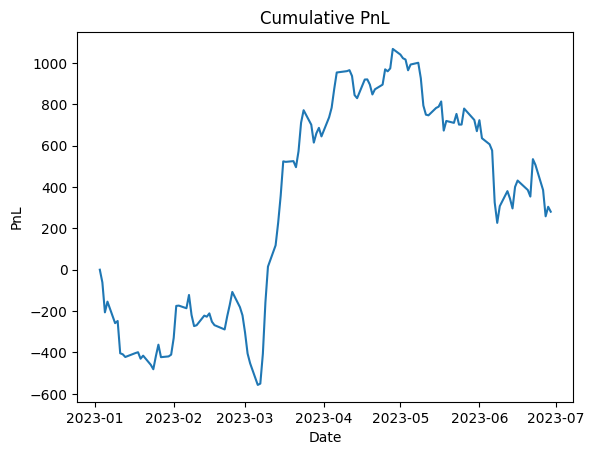

In [261]:
# Initialisation des signaux par date
date_to_signal = {}

# Boucle pour prédire avec chaque modèle
for ticker in X_test_full["ticker"].unique():
    print(f"Prédiction pour le ticker : {ticker}")

    # Filtrer les données de test pour ce ticker
    ticker_test_data = X_test_full[X_test_full["ticker"] == ticker]
    ticker_X_test = ticker_test_data.drop(columns=["ticker",'Date'], errors="ignore")
    print("ticker_test_data", ticker_test_data)
    print(ticker_X_test)
    # Récupérer le modèle associé
    ticker_model = models[ticker]

    # Prédire les signaux pour le ticker
    ticker_test_data["signal"] = ticker_model.predict(ticker_X_test)

    # Convertir les signaux en positions (1: long, -1: short)
    ticker_test_data["signal"] = ticker_test_data["signal"].apply(lambda x: 1 if x > 0 else -1)

    # Alimenter `date_to_signal` avec les signaux du ticker
    for date, group in ticker_test_data.groupby("Date"):
        if date not in date_to_signal:
            date_to_signal[date] = {}
        date_to_signal[date][ticker] = group["signal"].iloc[0]
    print("date_to_signal",date_to_signal)

# Vérification des signaux générés
print("Exemple de signaux générés par date :")
for date, signals in list(date_to_signal.items())[:5]:
    print(f"Date: {date}, Signals: {signals}")

# Préparer les prix par date et ticker pour le backtest
date_to_product_prices = {}
for date, group in X_test_full.groupby("Date"):
    date_to_product_prices[date] = group.set_index("ticker")[["open", "close"]].to_dict("index")

# Vérification des prix par date et ticker
print("Exemple de prix par date et ticker :")
for date, prices in list(date_to_product_prices.items())[:5]:
    print(f"Date: {date}, Prices: {prices}")

# Exécuter le backtest
fees_bps = 2  # Frais en basis points (0.05%)
cumulative_pnl = calculate_cumulative_pnl_v1(
    date_to_signal=date_to_signal,
    date_to_product_prices=date_to_product_prices,
    fees_bps=fees_bps,
    notional=10000,
    verbose=1
)

# Afficher les résultats
import matplotlib.pyplot as plt
plt.plot(cumulative_pnl.index, cumulative_pnl.values)
plt.title("Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.show()

In [262]:
date_to_signal

{Timestamp('2023-01-03 00:00:00'): {'AMZN': np.int64(1),
  'AAPL': np.int64(-1),
  'GOOG': np.int64(1),
  'BAC': np.int64(-1),
  'ADBE': np.int64(-1),
  'NVS': np.int64(1),
  'T': np.int64(-1)},
 Timestamp('2023-01-04 00:00:00'): {'AMZN': np.int64(1),
  'AAPL': np.int64(-1),
  'GOOG': np.int64(1),
  'BAC': np.int64(-1),
  'ADBE': np.int64(-1),
  'NVS': np.int64(1),
  'T': np.int64(-1)},
 Timestamp('2023-01-05 00:00:00'): {'AMZN': np.int64(-1),
  'AAPL': np.int64(1),
  'GOOG': np.int64(1),
  'BAC': np.int64(1),
  'ADBE': np.int64(-1),
  'NVS': np.int64(-1),
  'T': np.int64(1)},
 Timestamp('2023-01-06 00:00:00'): {'AMZN': np.int64(1),
  'AAPL': np.int64(-1),
  'GOOG': np.int64(1),
  'BAC': np.int64(1),
  'ADBE': np.int64(1),
  'NVS': np.int64(1),
  'T': np.int64(1)},
 Timestamp('2023-01-09 00:00:00'): {'AMZN': np.int64(1),
  'AAPL': np.int64(1),
  'GOOG': np.int64(1),
  'BAC': np.int64(-1),
  'ADBE': np.int64(-1),
  'NVS': np.int64(1),
  'T': np.int64(-1)},
 Timestamp('2023-01-10 00:00:0